\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}

\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center} 

# 1. {-}

## (a) {-}

In [45]:
# contents of problem1.py

import numpy as np

def get_data(n):
    np.random.seed(0)               # fix seed
    x = np.random.uniform(size=n)
    y = x**2-x/2.0 + np.random.normal(size=n,scale=0.1)
    idx = np.argsort(x)
    return(x[idx].reshape((-1,1)),y[idx].reshape((-1,1)))

def true_mean(x):
    return(x**2-x/2.0)


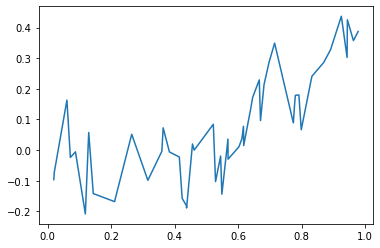

In [46]:
import matplotlib.pyplot as plt

X_train, y_train = get_data(50)
plt.plot(X_train, y_train)
plt.show()

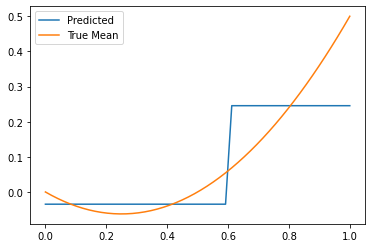

In [55]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=1).fit(x, y)
x = np.array(np.linspace(0, 1, num=50)).reshape(50, 1)
df = DataFrame({'Predicted': tree.predict(x), 'True Mean': true_mean(x).flatten()}, index=x.flatten())
df.plot()
plt.show()